# MURaM Atmosphere Statistics

In this notebook we look at some of the properties of the MURaM atmospheres.

In [1]:
import muram
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys

In [2]:
os.getpid() # for checking memory/CPU in terminal

55158

In [3]:
# Set the location of the MURaM data
dir2D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/2D"
dir3D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/3D"
iteration = 12000

## Mean Atmosphere

Below we compute the horizontally averaged atmosphere, in order to compare it to the standard FALC atmosphere.

Note: this goes over a lot of data and is slow.  An ugly, dirty trick is done to keep this procedure within memory limits.

In [4]:
def calc_means(iteration):
    snap = muram.MuramSnap(dir3D, iteration)

    # Build a height axis with 0 == tau1
    x = np.arange(snap.T.shape[0]) * 16. # km
    tau_mean = np.mean(snap.tau, axis=(1,2))
    tau1_ix = (np.abs(tau_mean - 1.0)).argmin()
    height = x - x[tau1_ix]

    names = ('height', 'T', 'P', 'rho', 'vx', 'vy', 'vz', 'vver', 'vhor', 'v', 'Bx', 'By', 'Bz', 'Bver', 'Bhor', 'B')
    formats = ['f'] * len(names)
    dtype = [x for x in zip(names, formats)]
    data = np.zeros(height.size, dtype=dtype)
    data['height'] = height
    
    # Note: this pulls a lot of data into memory
    # We delete the snapshot afterwards in order to return
    # resources to the shared cluster
    for var in ('T', 'P', 'rho'):
        data[var] = np.mean(getattr(snap, var), axis=(1,2))
        delattr(snap, var) # clear memory
    
    # Compute averages for cartesian component vectors and plane projections + full magnitude
    # cart: x, y, z components
    # planes: vertical, horizontal projections and vector magnitude
    for cart, planes in ((('Bx', 'By', 'Bz'), ('Bver', 'Bhor', 'B')), (('vx', 'vy', 'vz'), ('vver', 'vhor', 'v'))):
        sq = {} # square of cartesian components
        for var in cart:
            data[var] = np.mean(getattr(snap, var), axis=(1,2)) * np.sqrt(4 * np.pi)
            sq[var] = np.power(getattr(snap, var), 2)
            delattr(snap, var) # clear memory
        data[planes[0]] = np.mean(np.sqrt(sq[cart[0]]), axis=(1,2)) * np.sqrt(4 * np.pi)
        data[planes[1]] = np.mean(np.sqrt(sq[cart[1]] + sq[cart[2]]), axis=(1,2)) * np.sqrt(4 * np.pi)
        data[planes[2]] = np.mean(np.sqrt(sq[cart[0]] + sq[cart[1]] + sq[cart[2]]), axis=(1,2)) * np.sqrt(4 * np.pi)
        del sq

    return data

means = calc_means(iteration)

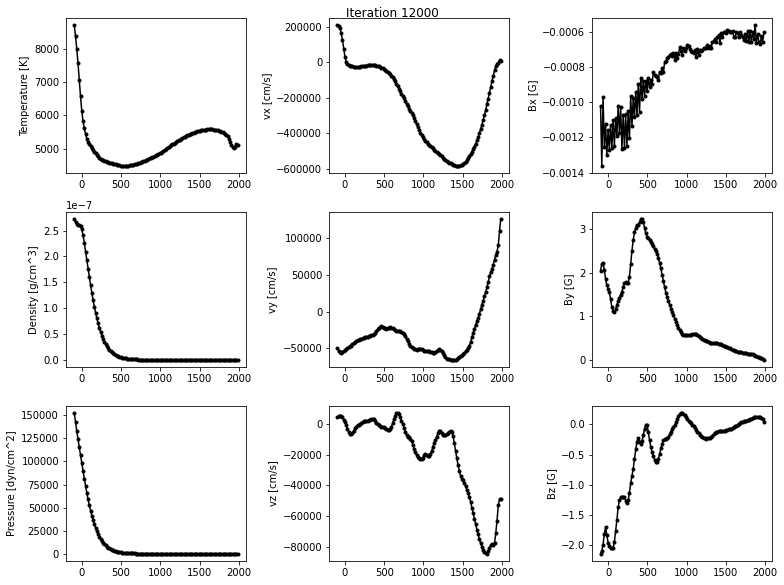

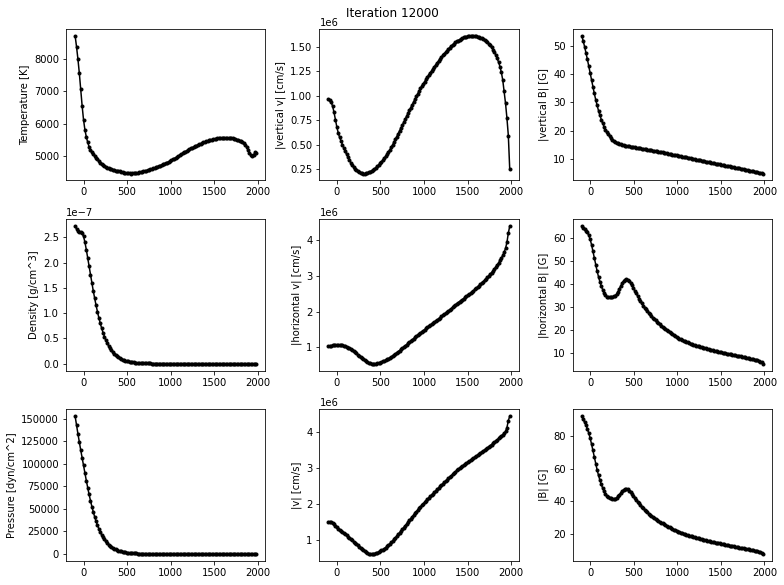

In [6]:
def plot_means(iteration, means=None, min_height=-100, planes=False, close=False):
    if means is None:
        means = calc_means(iteration)
    sel = means['height'] >= min_height

    fig, ((ax1, ax4, ax7), (ax2, ax5, ax8), (ax3, ax6, ax9)) = plt.subplots(3, 3, figsize=(11, 8.5))
    
    ax1.plot(means['height'][sel], means['T'][sel], 'k.-')
    ax1.set_ylabel('Temperature [K]')
    ax2.plot(means['height'][sel], means['rho'][sel], 'k.-')
    ax2.set_ylabel('Density [g/cm^3]')
    ax3.plot(means['height'][sel], means['P'][sel], 'k.-')
    ax3.set_ylabel('Pressure [dyn/cm^2]')

    if not planes:
        ax4.plot(means['height'][sel], means['vx'][sel], 'k.-')
        ax4.set_ylabel('vx [cm/s]')
        ax5.plot(means['height'][sel], means['vy'][sel], 'k.-')
        ax5.set_ylabel('vy [cm/s]')
        ax6.plot(means['height'][sel], means['vz'][sel], 'k.-')
        ax6.set_ylabel('vz [cm/s]')
        
        ax7.plot(means['height'][sel], means['Bx'][sel], 'k.-')
        ax7.set_ylabel('Bx [G]')
        ax8.plot(means['height'][sel], means['By'][sel], 'k.-')
        ax8.set_ylabel('By [G]')
        ax9.plot(means['height'][sel], means['Bz'][sel], 'k.-')
        ax9.set_ylabel('Bz [G]')
    else:
        ax4.plot(means['height'][sel], means['vver'][sel], 'k.-')
        ax4.set_ylabel('|vertical v| [cm/s]')
        ax5.plot(means['height'][sel], means['vhor'][sel], 'k.-')
        ax5.set_ylabel('|horizontal v| [cm/s]')
        ax6.plot(means['height'][sel], means['v'][sel], 'k.-')
        ax6.set_ylabel('|v| [cm/s]')
        
        ax7.plot(means['height'][sel], means['Bver'][sel], 'k.-')
        ax7.set_ylabel('|vertical B| [G]')
        ax8.plot(means['height'][sel], means['Bhor'][sel], 'k.-')
        ax8.set_ylabel('|horizontal B| [G]')
        ax9.plot(means['height'][sel], means['B'][sel], 'k.-')
        ax9.set_ylabel('|B| [G]')
        
    fig.suptitle(f"Iteration {iteration:5d}")
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.savefig(f'mean_atmos_{iteration:5d}.png')
    if close:
        plt.close(fig)
    
plot_means(iteration, means=means, planes=False)
plot_means(iteration, means=means, planes=True)

In [9]:
ix_minT = np.argmin(means['T'])
height_minT = means['height'][ix_minT]
T_min = means['T'][ix_minT]
ix_maxT = ix_minT + np.argmax(means['T'][ix_minT:])
height_maxT = means['height'][ix_maxT]
T_max = means['T'][ix_maxT]
print(f'T_min={T_min:0.1f} K ix={ix_minT} height={height_minT:0.0f} km T_max={T_max:0.1f} K ix={ix_maxT} height={height_maxT:0.0f} km')

T_min=4475.7 K ix=421 height=544 km T_max=5578.3 K ix=489 height=1632 km


### Iterate through all data cubes and plot mean atmosphere

In [ ]:
cube_iterations = muram.cube_iterations(dir3D)
cube_iterations = np.array(cube_iterations)
cube_iterations = cube_iterations[cube_iterations > 10000]
len(cube_iterations)